In [11]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import torch

In [12]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


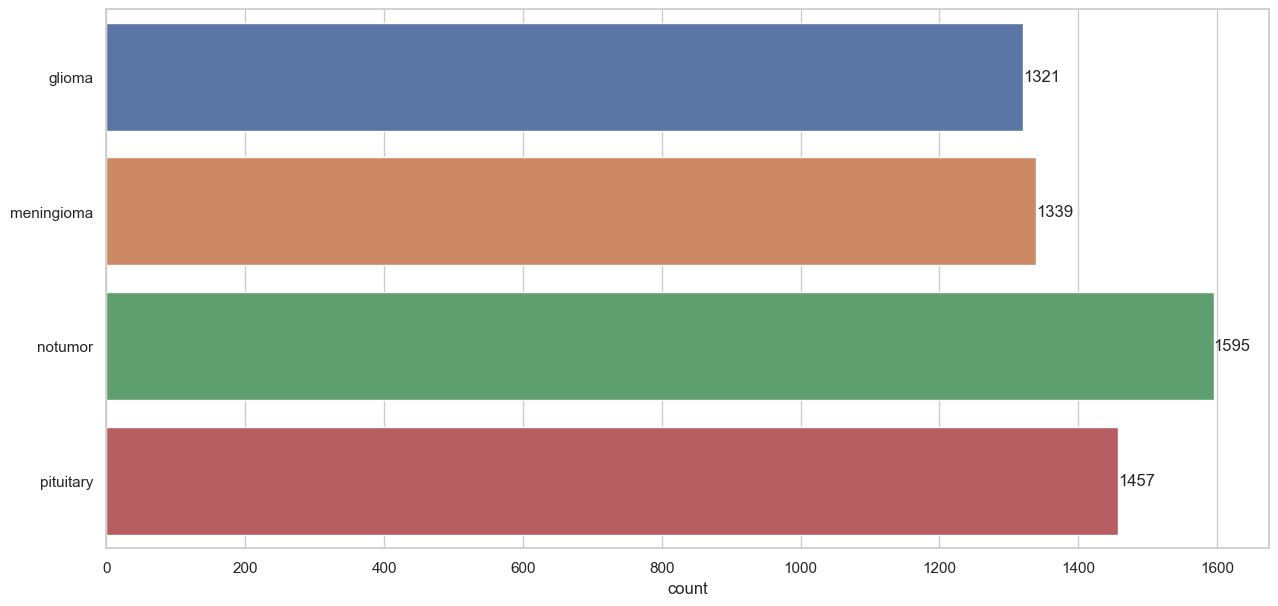

In [13]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

dataset_path = "data/Training"   # change to Testing if needed
dataset = BrainTumorDataset(dataset_path, transform=transform)

fig = plt.figure(figsize=(15, 7))
ax = sns.countplot(y=dataset.labels)
ax.set_yticklabels(dataset.classes)
ax.bar_label(ax.containers[0])
plt.show()


In [14]:
val_ration = 0.10
val_size = int(len(dataset) * val_ration)
train_size = len(dataset) - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size], generator=generator
)
print(f"Training size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")


Training size: 5141
Validation size: 571


Total images: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class Lengths: [300, 306, 405, 300]


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


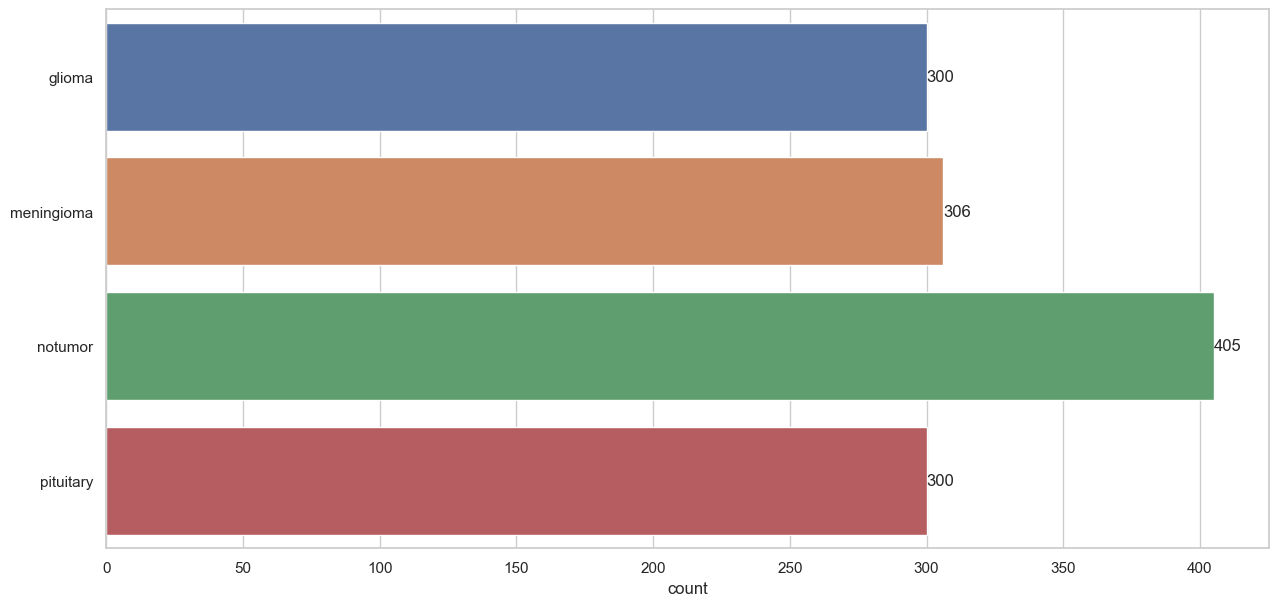

In [15]:
test_dataset_path = "data/Testing"
test_dataset = BrainTumorDataset(test_dataset_path, transform=transform)
print(f"Total images: {len(test_dataset)}")
print("Classes:", test_dataset.classes)
print("Class Lengths:", [test_dataset.labels.count(i) for i in range(len(test_dataset.classes))])
fig = plt.figure(figsize=(15, 7))
ax = sns.countplot(y=test_dataset.labels)
ax.set_yticklabels(test_dataset.classes)
ax.bar_label(ax.containers[0])
plt.show()

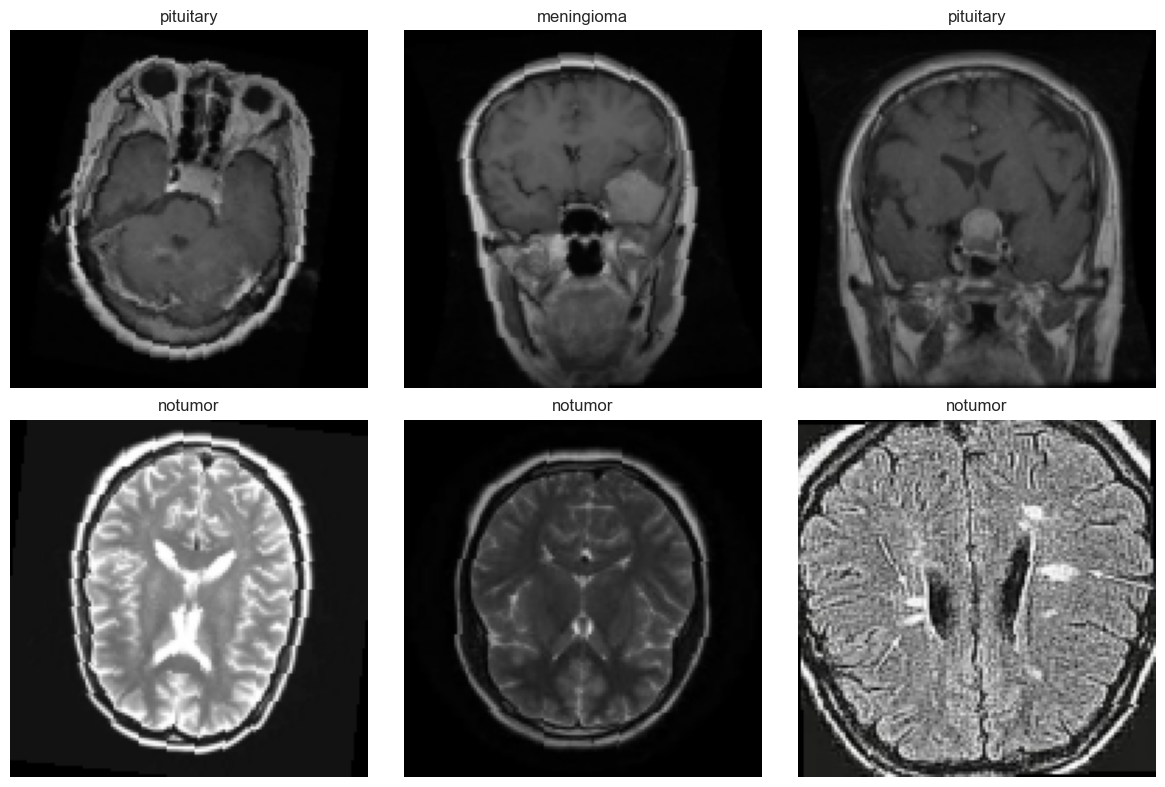

In [16]:
def show_random_images(dataset, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        image, label = dataset[idx]

        # Convert tensor → numpy image
        image_np = image.permute(1,2,0).numpy()

        plt.subplot(2, 3, i+1)
        plt.imshow(image_np)
        plt.title(dataset.classes[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(dataset, num_images=6)

In [17]:
trainloader = DataLoader(dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch
class CNN_network(nn.Module):
    def __init__(self, activation="relu", num_classes=4):
        super().__init__()

        activations = {
            "relu": F.relu,
            "tanh": torch.tanh,
            "sigmoid": torch.sigmoid,
            "leaky_relu": F.leaky_relu,
        }
        self.activation = activation
        self.activation_fn = activations[activation]

        # 1. Increase filters slightly to capture more detail
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Deeper filters

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # 2. CALCULATE FLATTEN SIZE
        # Assuming input image is 128x128:
        # After Pool 1: 64x64
        # After Pool 2: 32x32
        # After Pool 3: 16x16
        # Final shape: 128 channels * 16 * 16
        self.flatten_size = 128 * 16 * 16 

        # 3. Standard Dense Layers (No Global Pool bottleneck)
        self.fc1 = nn.Linear(self.flatten_size, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.latest_feature_map = None

    def forward(self, x):
        # Apply Pool at every step to reduce size gradually
        x = self.activation_fn(self.conv1(x))
        x = self.pool(x) # 128 -> 64
        self.latest_feature_map = x.detach().cpu()

        x = self.activation_fn(self.conv2(x))
        x = self.pool(x) # 64 -> 32

        x = self.activation_fn(self.conv3(x))
        x = self.pool(x) # 32 -> 16
        
        # Flatten preserves all spatial info
        x = torch.flatten(x, 1) 

        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        
        x = self.activation_fn(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

In [19]:
from torchsummary import summary
summary(CNN_network(activation="relu", num_classes=4), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 512]      16,777,728
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
          Dropout-10                  [-1, 128]               0
           Linear-11                    [-1, 4]             516
Total params: 16,937,156
Trainable params: 16,937,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Fo

In [ ]:
def train(model, trainloader, valloader, device, epochs=20, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    history = {
        "train_loss": [], "train_acc": [], 
        "val_loss": [], "val_acc": []
    }

    print(f"{'Epoch':^10} | {'Train Loss':^12} | {'Train Acc':^12} | {'Val Loss':^12} | {'Val Acc':^12}")
    print("-" * 70)

    for epoch in range(epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Normalize: multiply avg batch loss by batch_size to get total sum
            running_loss += loss.item() * images.size(0) 
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss per image and accuracy
        epoch_loss = running_loss / total 
        epoch_acc = correct / total
        
        # --- VALIDATION PHASE ---
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for val_images, val_labels in valloader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                
                # Validation Loss
                v_loss = criterion(val_outputs, val_labels)
                val_running_loss += v_loss.item() * val_images.size(0)
                
                # Validation Accuracy
                _, val_predicted = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (val_predicted == val_labels).sum().item()
                
                all_preds.extend(val_predicted.cpu().numpy())
                all_labels.extend(val_labels.cpu().numpy())
                probs = F.softmax(val_outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
        
        val_loss = val_running_loss / total_val
        val_acc = correct_val / total_val

        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        # Print normalized metrics (Loss is raw, Accuracy is %)
        print(f"{epoch+1:^10} | {epoch_loss:^12.4f} | {epoch_acc*100:^11.2f}% | {val_loss:^12.4f} | {val_acc*100:^11.2f}%")
    
    return {
        "history": history,
        "preds": np.array(all_preds),
        "labels": np.array(all_labels),
        "probs": np.array(all_probs)
    }

Using device: mps


In [21]:
model = CNN_network(activation="relu", num_classes=len(dataset.classes))
info = train(model, trainloader, testloader, device, epochs=5)

Epoch [1/5] Train Loss: 22.5755, Train Acc: 0.7131 | Val Loss: 0.7414, Val Acc: 23.7073
Epoch [2/5] Train Loss: 13.9212, Train Acc: 0.8347 | Val Loss: 0.8337, Val Acc: 26.6585
Epoch [3/5] Train Loss: 10.5642, Train Acc: 0.8752 | Val Loss: 0.8497, Val Acc: 27.1707
Epoch [4/5] Train Loss: 8.8064, Train Acc: 0.8958 | Val Loss: 0.8543, Val Acc: 27.3171
Epoch [5/5] Train Loss: 7.1980, Train Acc: 0.9125 | Val Loss: 0.9100, Val Acc: 29.0976


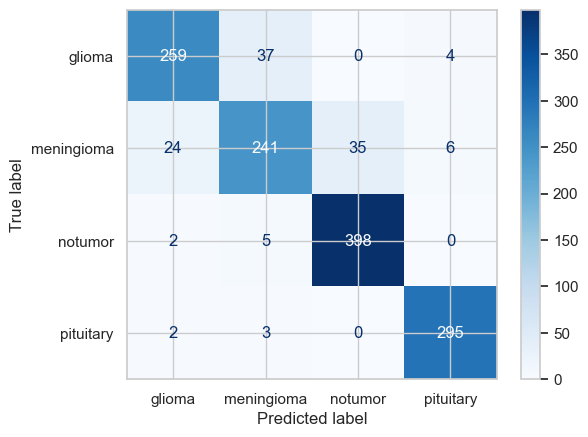

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_true=info['labels'], y_pred=info['preds'], labels=range(len(dataset.classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [23]:
report = classification_report(info['labels'], info['preds'], target_names=dataset.classes, output_dict=True)
print("Classification Report: \n",report)

Classification Report: 
 {'glioma': {'precision': 0.9024390243902439, 'recall': 0.8633333333333333, 'f1-score': 0.8824531516183987, 'support': 300}, 'meningioma': {'precision': 0.8426573426573427, 'recall': 0.7875816993464052, 'f1-score': 0.8141891891891891, 'support': 306}, 'notumor': {'precision': 0.9191685912240185, 'recall': 0.9827160493827161, 'f1-score': 0.9498806682577565, 'support': 405}, 'pituitary': {'precision': 0.9672131147540983, 'recall': 0.9833333333333333, 'f1-score': 0.9752066115702478, 'support': 300}, 'accuracy': 0.9099923722349351, 'macro avg': {'precision': 0.9078695182564259, 'recall': 0.904241103848947, 'f1-score': 0.905432405158898, 'support': 1311}, 'weighted avg': {'precision': 0.9084760244410197, 'recall': 0.9099923722349351, 'f1-score': 0.9085747456086021, 'support': 1311}}


,glioma,meningioma,notumor,pituitary,accuracy,macro avg,weighted avg
precision,0.902439,0.842657,0.919169,0.967213,0.909992,0.907870,0.908476
recall,0.863333,0.787582,0.982716,0.983333,0.909992,0.904241,0.909992
f1-score,0.882453,0.814189,0.949881,0.975207,0.909992,0.905432,0.908575
support,300.000000,306.000000,405.000000,300.000000,0.909992,1311.000000,1311.000000


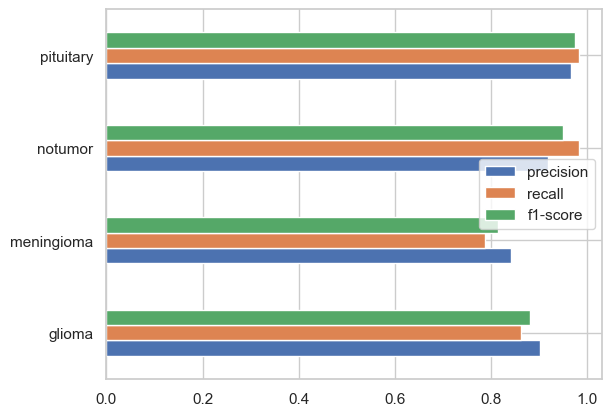

In [24]:
import pandas as pd
from IPython import display
display.display(pd.DataFrame(report))
df = pd.DataFrame(report)
df.iloc[:3, :4].T.plot(kind='barh')
plt.show()

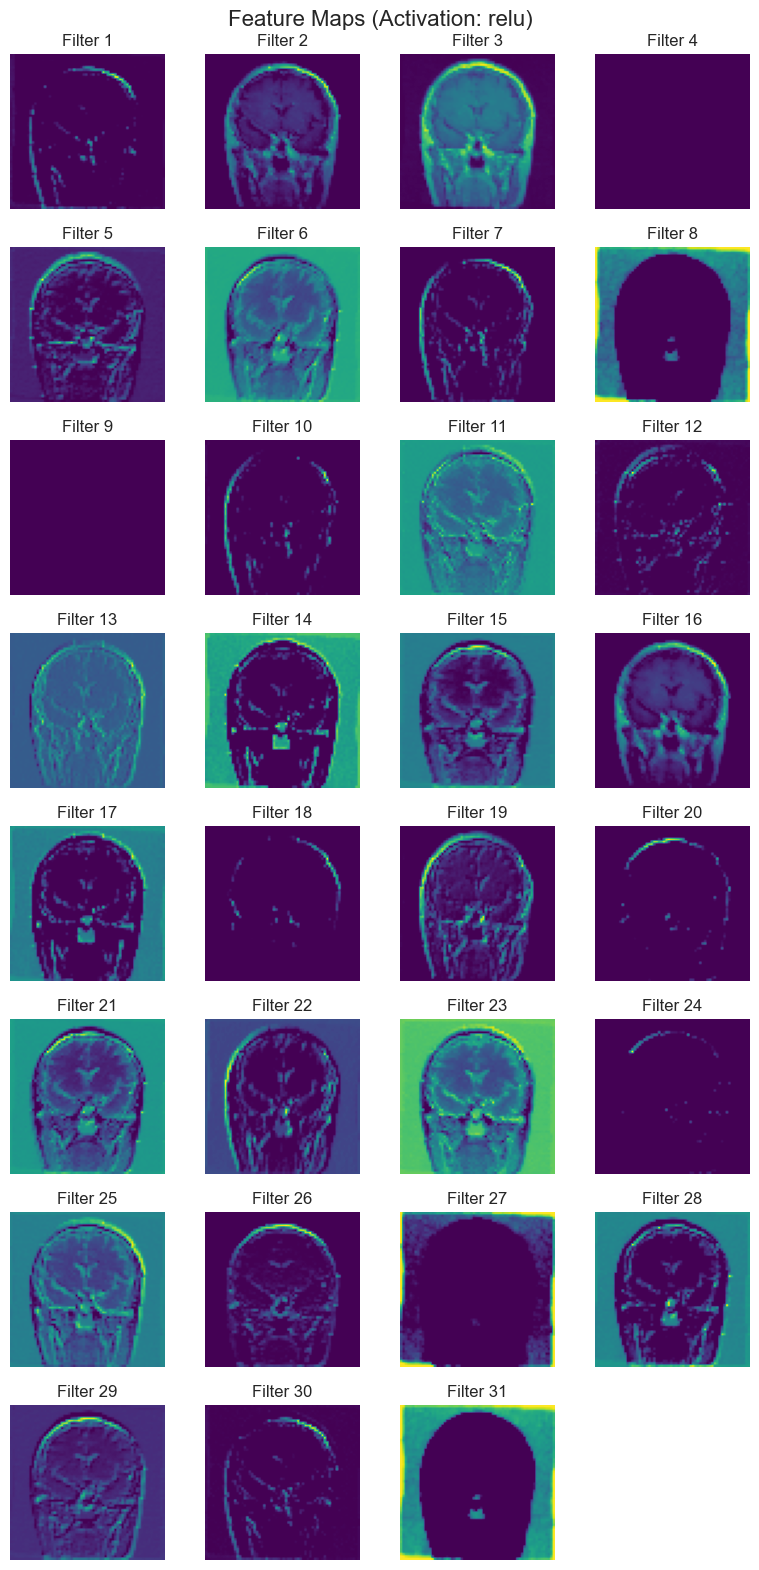

In [25]:
def plot_feature_maps(model): 
    if model.latest_feature_map is None:
        print("No feature map available. Run a forward pass first.")
        return
    
    feature_map = model.latest_feature_map
    num_features = feature_map.shape[0]
    size = feature_map.shape[0]
    cols = 4
    rows = int(np.ceil(num_features / cols))
    plt.figure(figsize=(cols * 2, rows * 2))
    plt.suptitle(f"Feature Maps (Activation: {model.activation})", fontsize=16)
    for i in range(num_features):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_map[0, i, :, :], cmap='viridis')
        plt.axis('off')
        plt.title(f"Filter {i+1}")
    plt.tight_layout()
    plt.show()

plot_feature_maps(model)

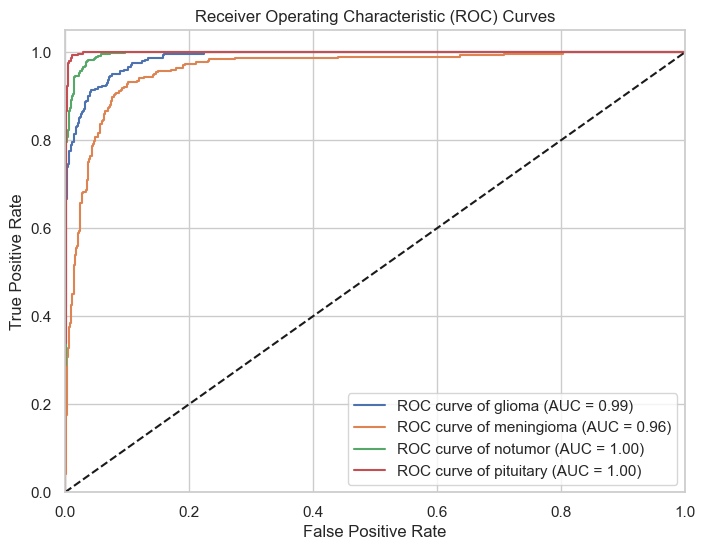

In [26]:
def plot_roc_curve(info, class_names):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import matplotlib.pyplot as plt
    import numpy as np

    y_true = np.array(info['labels'])
    y_prob = np.array(info['probs'])

    n_classes = y_prob.shape[1]

    # Binarize labels: 0,1,2,3 → one-hot
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))

    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(
            y_true_binarized[:, i],
            y_prob[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})'
        )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(info, trainloader.dataset.classes)

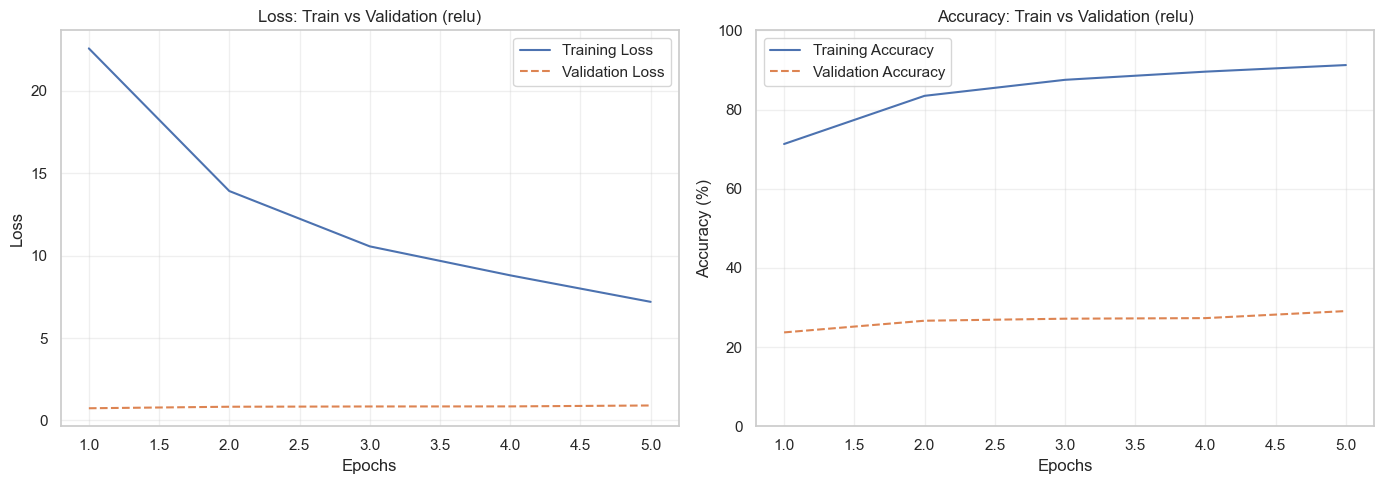

In [40]:
def plot_training_history(history, activation_name):
    """Plots Train vs Validation Loss and Accuracy with proper scaling."""
    epochs = range(1, len(history['train_loss']) + 1)

    # Convert accuracy to percentage
    train_acc = [acc * 100 for acc in history['train_acc']]
    val_acc = history['val_acc']  # already in %

    plt.figure(figsize=(14, 5))

    # -------- Loss Plot --------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], linestyle='--', label='Validation Loss')
    plt.title(f"Loss: Train vs Validation ({activation_name})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # -------- Accuracy Plot --------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, linestyle='--', label='Validation Accuracy')
    plt.title(f"Accuracy: Train vs Validation ({activation_name})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(info['history'], activation_name=model.activation)

In [28]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    return {
        "accuracy": accuracy,
        "preds": np.array(all_preds),
        "labels": np.array(all_labels),
        "probs": np.array(all_probs)
    }

eval_info = evaluate(model, testloader, device)
print(f"Test Accuracy: {eval_info['accuracy']:.4f}")

Test Accuracy: 0.9169


In [29]:
def confusion_matrix_plot(info, class_names):
    cm = confusion_matrix(y_true=info['labels'], y_pred=info['preds'], labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [43]:
def compare_activations(activations, trainloader, valloader, testloader, device, epochs=1):
    results = {}
    for activation in activations:
        print(f"\nTraining with activation: {activation}")
        model = CNN_network(activation=activation, num_classes=len(dataset.classes))
        info = train(model, trainloader, valloader, device, epochs=epochs)
        confusion_matrix_plot(info, trainloader.dataset.classes)
        plot_training_history(info['history'], activation_name=activation)
        plot_roc_curve(info, trainloader.dataset.classes)
        plot_feature_maps(model)
        report = classification_report(info['labels'], info['preds'], target_names=dataset.classes, output_dict=True)
        print("Classification Report: \n",report)

        test_info = evaluate(model, testloader, device)
        print(f"Test Accuracy: {eval_info['accuracy']:.4f}")
        results[activation] = {
            "train_info": info,
            "test_info": test_info
        }
        
    return results


Training with activation: relu
Epoch [1/5] Train Loss: 24.6336, Train Acc: 0.6893 | Val Loss: 0.7671, Val Acc: 24.3333
Epoch [2/5] Train Loss: 15.9148, Train Acc: 0.8134 | Val Loss: 0.8389, Val Acc: 26.6111
Epoch [3/5] Train Loss: 13.0033, Train Acc: 0.8461 | Val Loss: 0.8354, Val Acc: 26.5000
Epoch [4/5] Train Loss: 10.8472, Train Acc: 0.8701 | Val Loss: 0.9107, Val Acc: 28.8889
Epoch [5/5] Train Loss: 8.5006, Train Acc: 0.9000 | Val Loss: 0.9440, Val Acc: 29.9444


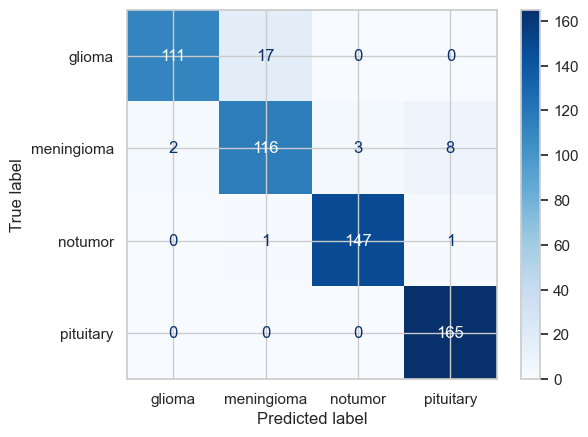

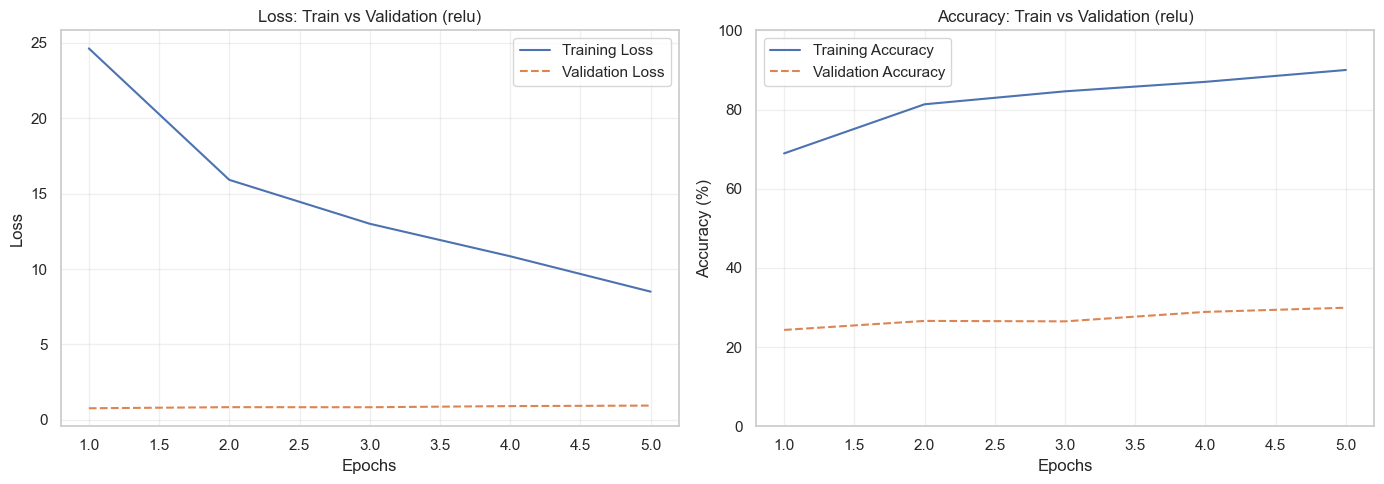

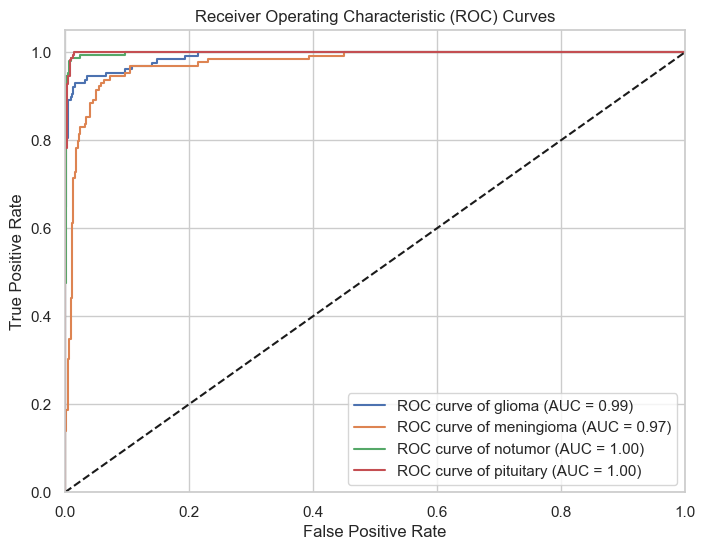

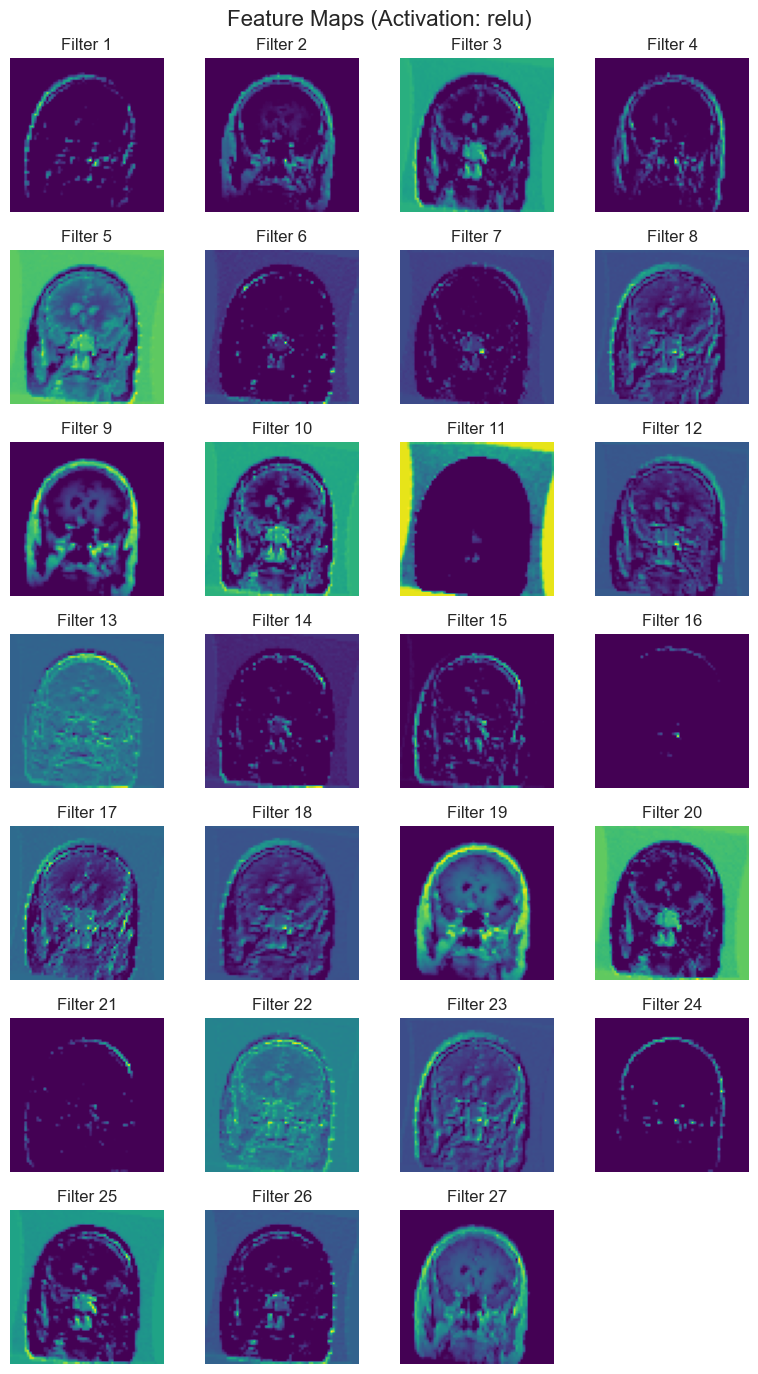

Classification Report: 
 {'glioma': {'precision': 0.9823008849557522, 'recall': 0.8671875, 'f1-score': 0.921161825726141, 'support': 128}, 'meningioma': {'precision': 0.8656716417910447, 'recall': 0.8992248062015504, 'f1-score': 0.8821292775665398, 'support': 129}, 'notumor': {'precision': 0.98, 'recall': 0.9865771812080537, 'f1-score': 0.9832775919732442, 'support': 149}, 'pituitary': {'precision': 0.9482758620689655, 'recall': 1.0, 'f1-score': 0.9734513274336283, 'support': 165}, 'accuracy': 0.9439579684763573, 'macro avg': {'precision': 0.9440620972039406, 'recall': 0.938247371852401, 'f1-score': 0.9400050056748883, 'support': 571}, 'weighted avg': {'precision': 0.9455195662114892, 'recall': 0.9439579684763573, 'f1-score': 0.9436623830640837, 'support': 571}}
Test Accuracy: 0.9169

Training with activation: tanh
Epoch [1/5] Train Loss: 26.5002, Train Acc: 0.6600 | Val Loss: 0.7793, Val Acc: 24.7222
Epoch [2/5] Train Loss: 20.3833, Train Acc: 0.7407 | Val Loss: 0.8249, Val Acc: 26.16

In [ ]:
compare_activations(["relu", "tanh", "sigmoid", "leaky_relu"], trainloader, valloader, testloader, device, epochs=5)